In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import pylablib as pll
pll.par["devices/dlls/andor_sdk3"] = "C:\Program Files\Andor SDK3" # path to Andor SDK3 dlls
from pylablib.devices import Andor

from qdm.system.system import System
from qdm.devices.pulseblaster.spinapi import *
from qdm.devices.andor.zyla_4_2 import Zyla
from qdm.devices.andor.sona import Sona
import qdm.devices.pulseblaster.spinapi as pb

In [3]:
# Make a fake system for testing the camera without the system class. 
qdm = System(name = "Chroma",
             tag="testing",
             config_file='C:\qdm-control\src\qdm\system\cryo.json') 



Using the custom tag: ( testing ) for the data directory.
connecting to Sona
Connected to Camera: SONA-4BV6U
TCPIP0::169.254.33.129::inst0::INSTR
Rohde&Schwarz,SMB100A,1406.6000k02/106177,3.0.13.0-2.20.382.35



In [5]:
qdm.cam.get_all_attr()

Dictionary('AOIBinning': 1x1
'AOIHBin': 1
'AOIHeight': 2046
'AOILayout': Image
'AOILeft': 1
'AOIStride': 4096
'AOITop': 1
'AOIVBin': 1
'AOIWidth': 2048
'AccumulateCount': 1
'AuxOutSourceTwo': ExternalShutterControl
'AuxiliaryOutSource': FireRow1
'Baseline': 100
'BitDepth': 16 Bit
'BytesPerPixel': 2.0
'CameraAcquiring': False
'CameraFamily': Andor sCMOS
'CameraModel': SONA-4BV6U
'CameraName': Sona
'CameraPresent': True
'CycleMode': Fixed
'ElectronicShutteringMode': Rolling
'EventEnable': True
'EventSelector': BufferOverflowEvent
'ExposureTime': 0.0
'ExternalTriggerDelay': 0.0
'FanSpeed': On
'FirmwareVersion': 23.10.19.12597
'FrameCount': 1
'FrameRate': 73.76589655070667
'FullAOIControl': True
'I2CByte': 207
'I2CByteCount': 1
'I2CByteSelector': 0
'IOInvert': False
'IOSelector': Fire 1
'ImageSizeBytes': 8380416
'MetadataEnable': False
'MetadataFrame': True
'MetadataFrameInfo': True
'MetadataTimestamp': True
'MicrocodeVersion': 2008
'MultitrackBinned': True
'MultitrackCount': 1
'Multitrack

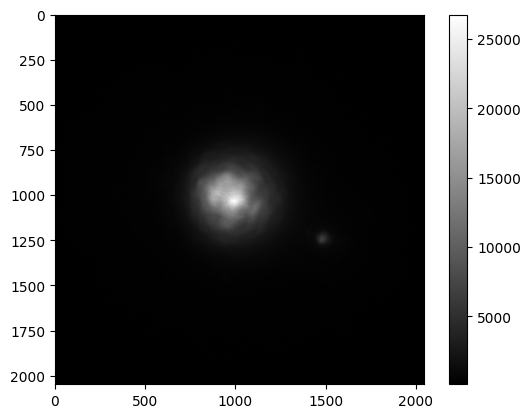

In [4]:
# grab a single frame from the camera with the set exposure time
qdm.laser_output(1)
qdm.cam.set_trigger_mode('int')
qdm.cam.exposure = 0.05
image = qdm.cam.get_frame(num_frames = 1)  # grab 1 frames
# Plot the image
plt.figure()
plt.imshow(image, cmap='gray', interpolation='none')
plt.colorbar()
plt.show()

In [7]:
qdm.laser_output(1)
time, intensity = qdm.cam.video()
qdm.laser_output(0)

201


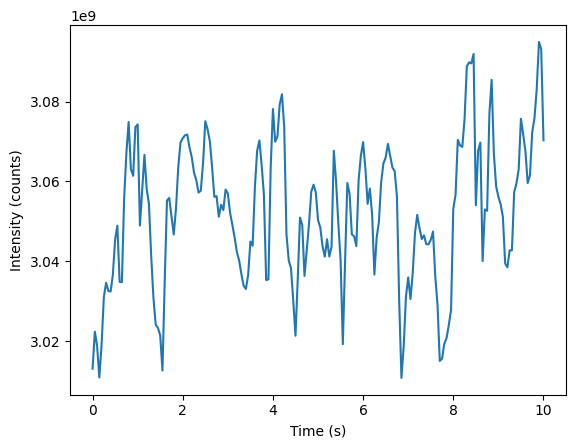

In [9]:
# change plotting back to inline
%matplotlib inline
print(len(intensity))

plt.figure()
plt.plot(time, intensity)
plt.xlabel('Time (s)')
plt.ylabel('Intensity (counts)')
plt.show()

# Check triggering with the system

In [ ]:
# Load the system for testing the pulseblaster
qdm = System(name = "GMX",
    tag = "testing_comms",
    config_file = '../../src/qdm/config/GMX.json')


In [ ]:
from qdm.devices.pulseblaster.utils import *
# Turn the laser on
qdm.laser_output(1)

# grab a single frame from the camera with the set exposure time
# qdm.cam.exposure = 0.01 # set exposure time to 10 ms
# cam.roi =[512, 2560-512, 512, 2560-512]
qdm.cam.image_size = [512, 512]
qdm.cam.bin = 2
qdm.cam.set_trigger_mode("int")
image = qdm.cam.get_frame(num_frames = 1)  # grab 1 frames
# Plot the image
plt.figure()
plt.imshow(image[0], cmap='gray', interpolation='none')
plt.colorbar()

# Turn the laser off
qdm.laser_output(0)

In [ ]:
import time
time.time()

In [ ]:
# get a live camera feed 
from matplotlib.animation import FuncAnimation
import time
%matplotlib qt
# %matplotlib inline

qdm.cam.exposure = 0.01 # set exposure time to 10 ms

qdm.laser_output(1)

plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2,1)
ax1.set_title("Camera Feed")
ax2 = plt.subplot(1,2,2)
#create two image plots
frame = qdm.cam.get_frame(num_frames = 1) 
im1 = ax1.imshow(frame[0,::])

avg_counts = []
timing = []
avg_counts.append(np.sum(frame, axis=(1,2))[0])

start_time = time.time()
timing.append(0)
line, = ax2.plot(timing, avg_counts)

def update(i):
    # get the different in time in seconds since the last update
    timing.append(time.time() - start_time)
    frame = qdm.cam.get_frame(num_frames = 1) 
    im1.set_data(frame[0,::])
    ax1.relim()
    ax1.autoscale_view()

    avg_counts.append(np.sum(frame, axis=(1,2))[0])
    line.set_xdata(timing) 
    line.set_ydata(avg_counts)
    ax2.relim()
    ax2.autoscale_view()


ani = FuncAnimation(plt.gcf(), update, interval=10)
plt.show()

# qdm.laser_output(0)

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(timing, avg_counts)

In [ ]:
qdm.laser_output(0)
%matplotlib notebook

In [ ]:
def odmr_sequence(
        flags,
        reference: bool = False,
        reference_type: str = 'no_mw',
        int_time: float = 150.0,
        number_of_frames: int = 1
        ):


    def define_pulse(flag_list):
        command_num = 0
        for idx in range(len(flag_list)):
            command_num = command_num + int(flag_list[idx], 2) 
        return command_num


    # Start the programming of the pulseblaster
    pb_start_programming(PULSE_PROGRAM)

    # write the pulse sequence
    # pb_inst_pbonly(Flag, Inst command, Valye, Time)
    # check the system information for the flag definition
    control = define_pulse(flags['camera']) 
    pb_inst_pbonly(control, Inst.CONTINUE, 0, 10.0 * ms)
    # laser = 1, camera trigger = 1
    for i in range(1, number_of_frames + 1):

        control = define_pulse([flags['laser'], flags['mw_x']])
        pb_inst_pbonly(control,Inst.CONTINUE,0, int_time * ms)

        control = define_pulse([flags['laser'], flags['mw_x'], flags['camera'], flags['rf_trig']])
        pb_inst_pbonly(control,Inst.CONTINUE, 0, 10 * ms)


    # Turn the laser off and end sequence
    pb_inst_pbonly(0, Inst.STOP, 0, 1.0 * ms)

    # End of pulse program
    pb_stop_programming()

In [ ]:
import time

nframes = 10
reference = False

odmr_sequence(qdm.ch_defs, reference=reference, number_of_frames=nframes, int_time=5.0)

# setting up the trigger mode can testing 
qdm.cam.set_trigger_mode("ext_start") # set up the trigger mode
# if reference:    
#     cam.setup_acquisition(mode="sequence", nframes=2*nframes) 
# else: 
qdm.cam.setup_acquisition(mode="sequence", nframes=nframes) 

qdm.pb.reset()
# start the acquisition
qdm.cam.start_acquisition()
qdm.pb.start()

while qdm.pb.read_status() == 4:
    time.sleep(0.1)
    
qdm.pb.stop()
qdm.cam.stop_acquisition()

In [ ]:
# Get all of the frames from the camera
images = qdm.cam.get_all_frames()

In [ ]:
print(len(images))

plt.figure()
plt.imshow(images[0], cmap='gray', interpolation='none')
plt.colorbar()

In [ ]:
qdm.close()